Author : Aadya Aneesh Chinubhai 

Key Steps :
Build U-Net Class,
Define Activation function candidates,
Compare Accuracy & Training time.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from keras import metrics
import keras
import os
import random
from tqdm import tqdm 
from zipfile import ZipFile
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class UNet:
    
    def __init__(self, input_shape_,  activation_ = "relu"):
        self.activation = activation_
        self.input_shape = input_shape_
    
    def dice_coef(self, y_true, y_pred, smooth=100):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return dice
    
    def dice_coef_loss(self, y_true, y_pred):
        return -self.dice_coef(y_true, y_pred)
    
    def iou(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        def f(y_true, y_pred):
            intersection = (y_true * y_pred).sum()
            union = y_true.sum() + y_pred.sum() - intersection
            x = (intersection + 1e-15) / (union + 1e-15)
            x = x.astype(np.float32)
            return x
        
        return tf.numpy_function(f, [y_true, y_pred], tf.float32)

    def buildModel(self):
        
        # Lets create the DownSampling Blocks 
        kernel_initializer =  'he_uniform'
         
        inputs = tf.keras.Input(shape = self.input_shape)
        
        # Block - 1
    
        s = inputs

        #Contraction path
        c1 = Conv2D(16, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(s)
#         c1 = Dropout(0.1)(c1)
        c1 = Conv2D(16, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c1)
        p1 = MaxPooling2D((2, 2))(c1)

        c2 = Conv2D(32, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(p1)
#         c2 = Dropout(0.1)(c2)
        c2 = Conv2D(32, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c2)
        p2 = MaxPooling2D((2, 2))(c2)

        c3 = Conv2D(64, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(p2)
#         c3 = Dropout(0.2)(c3)
        c3 = Conv2D(64, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c3)
        p3 = MaxPooling2D((2, 2))(c3)

        c4 = Conv2D(128, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(p3)
#         c4 = Dropout(0.2)(c4)
        c4 = Conv2D(128, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c4)
        p4 = MaxPooling2D(pool_size=(2, 2))(c4)
        
        c_x = Conv2D(128, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(p3)
#         c4 = Dropout(0.2)(c4)
        c_x = Conv2D(128, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c4)
        p_x = MaxPooling2D(pool_size=(2, 2))(c4)

        c5 = Conv2D(256, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(p_x)
#         c5 = Dropout(0.3)(c5)
        c5 = Conv2D(256, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c5)

        #Expansive path 
        u_x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
        u_x = concatenate([u_x, c_x])
        c_x = Conv2D(32, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(u_x)
#         c8 = Dropout(0.1)(c8)
        c_x = Conv2D(32, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c_x)
    
        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(u6)
#         c6 = Dropout(0.2)(c6)
        c6 = Conv2D(128, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(u7)
#         c7 = Dropout(0.2)(c7)
        c7 = Conv2D(64, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(u8)
#         c8 = Dropout(0.1)(c8)
        c8 = Conv2D(32, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c8)

    
        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c1])
        c9 = Conv2D(16, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(u9)
#         c9 = Dropout(0.1)(c9)
        c9 = Conv2D(16, (3, 3), activation= self.activation, kernel_initializer=kernel_initializer, padding='same')(c9)

        
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

        model = Model(inputs=[inputs], outputs=[outputs])
        #compile model outside of this function to make it flexible. 
        model.summary()

        return model
 
    
    def CompileandSummarize(self, model_):
        model_.compile(optimizer = tf.keras.optimizers.Adam(), loss = self.dice_coef_loss, metrics = self.iou)

In [3]:
'''Defining callbacks to calculate training time '''

from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


In [4]:
# Now lets focus on preparing the data

with ZipFile("../input/data-science-bowl-2018/stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_train")
    
with ZipFile("../input/data-science-bowl-2018/stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_test")    

In [5]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 96
IMG_HEIGHT = 96
IMG_CHANNELS = 3

TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

In [6]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

train_ids[:5]

['e66a97b2c77f3d66a7d3cebbc6a36c8c6259368a397f7b67647ed80ad53aa776',
 '8aa1a883f61f0bb5af3d3d60acaaf33af45ef4fbffaac15ae838bc1ce37b6fbf',
 '8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175',
 '1d4a5e729bb96b08370789cad0791f6e52ce0ffe1fcc97a04046420b43c851dd',
 'b2c5d8653c621207e97b699e5c4c05d13df4f02d9db3e594b1f0c22e5b746aae']

In [7]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, file_name in tqdm(enumerate(train_ids)):   
    path = TRAIN_PATH + file_name
    img = imread(path + '/images/' + file_name + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Resizing training images and masks


0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
670it [04:52,  2.29it/s]


In [8]:
# 5% Validation Images (34 Images)
X_test, y_test  = X_train[636:], Y_train[636:]
X_train, Y_train = X_train[0: 636], Y_train[0:636]

In [9]:
(X_train.shape, Y_train.shape), (X_test.shape, y_test.shape)

(((636, 96, 96, 3), (636, 96, 96, 1)), ((34, 96, 96, 3), (34, 96, 96, 1)))

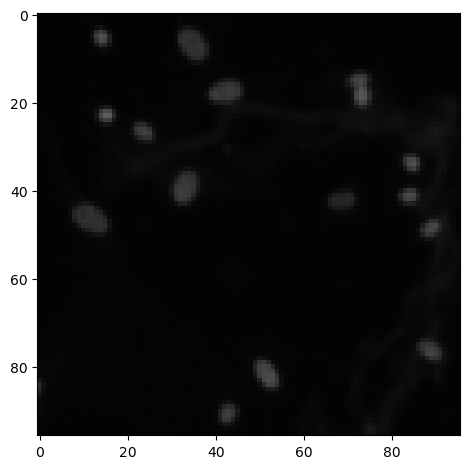

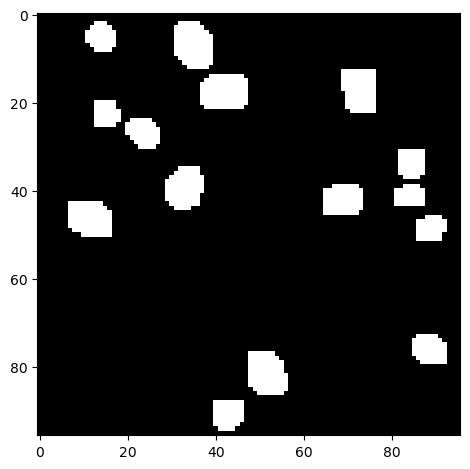

In [10]:
image_x = random.randint(0, 636)
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [11]:
class MexicanReLU(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0, sigma=1.0, mu=0.0):
        super(MexicanReLU, self).__init__()
        self.alpha = tf.Variable(alpha, trainable=True)
        self.sigma = tf.Variable(sigma, trainable=True)
        self.mu = tf.Variable(mu, trainable=True)

    def call(self, inputs):
        relu = tf.nn.relu(inputs)
        gaussian = self.alpha * tf.exp(-tf.square(inputs - self.mu) / (2 * tf.square(self.sigma))) * (inputs - self.mu)
        return relu + gaussian


In [12]:
# class SymmetricGaLU(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(SymmetricGaLU, self).__init__(**kwargs)

#     def call(self, x):
#         a, b = tf.split(x, 2, axis=-1)
#         return tf.multiply(tf.nn.tanh(a), tf.nn.sigmoid(b))

#     def get_config(self):
#         config = super(SymmetricGaLU, self).get_config()
#         return config

class Gelu(tf.keras.layers.Layer):
    def __init__(self):
        super(Gelu, self).__init__()

    def call(self, inputs):
        cdf = 0.5 * (1.0 + tf.math.erf(inputs / tf.sqrt(2.0)))
        return inputs * cdf


In [13]:
class Swish(tf.keras.layers.Layer):
    def __init__(self):
        super(Swish, self).__init__()

    def call(self, inputs):
        return inputs * tf.keras.backend.sigmoid(inputs)


In [14]:
class TrainableLeakyReLU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer=tf.initializers.constant(0.2), **kwargs):
        super(TrainableLeakyReLU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
    
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(), initializer=self.alpha_initializer, trainable=True, name="alpha")
        super(TrainableLeakyReLU, self).build(input_shape)
    
    def call(self, inputs):
        return tf.maximum(inputs, self.alpha * inputs)
    
    def get_config(self):
        config = super(TrainableLeakyReLU, self).get_config()
        config.update({"alpha_initializer": self.alpha_initializer})
        return config

In [15]:
class ISRU(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super(ISRU, self).__init__(**kwargs)
        self.alpha = tf.Variable(initial_value=alpha, trainable=True, name='alpha')

    def call(self, inputs):
        return inputs / tf.sqrt(1.0 + self.alpha * tf.square(inputs))


In [16]:
class Mish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs * tf.math.tanh(tf.math.softplus(inputs))


In [17]:
from tensorflow.keras.layers import Layer

class gated_swish(Layer):
    
    def __init__(self):
        super(gated_swish, self).__init__()

    def call(self, inputs):

        """
        Gated Swish activation function.
        """
        gate = tf.math.sigmoid(inputs)
        activation = tf.nn.swish(inputs)
        
        return gate * activation

In [18]:
class SeLU(tf.keras.layers.Layer):
    def __init__(self, alpha=1.6732632423543772848170429916717, scale=1.0507009873554804934193349852946, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.scale = scale

    def call(self, inputs):
        return self.scale * tf.where(inputs > 0.0, inputs, self.alpha * tf.exp(inputs) - self.alpha)

    def get_config(self):
        config = super().get_config()
        config.update({'alpha': self.alpha, 'scale': self.scale})
        return config


In [19]:
import tensorflow as tf

class LearnableSwish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LearnableSwish, self).__init__(**kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(shape=(1, ), initializer="ones", trainable=True)
        super(LearnableSwish, self).build(input_shape)

    def call(self, inputs):
        return tf.nn.swish(inputs * self.beta)

In [20]:
class SRS(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super(SRS, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        return tf.maximum(inputs, self.alpha * (tf.sigmoid(inputs) - 0.5))


In [21]:
class TanELU(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super(TanELU, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = self.alpha * (tf.exp(inputs) - 1)
        return tf.where(inputs > 0, tf.tanh(pos), tf.tanh(neg))

In [22]:
# !mkdir /kaggle/working/logs

In [23]:
training_inferences={}

In [24]:
cb = TimingCallback()

UNet_1 = UNet((96, 96, 3), activation_= MexicanReLU())
model1 = UNet_1.buildModel()
UNet_1.CompileandSummarize(model1)
results1 = model1.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],  validation_data = (X_test, y_test))

training_inferences['MexicanReLU'] = sum(cb.logs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 16)   451         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 16)   2323        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 48, 16)   0           ['conv2d_1[0][0]']               
                                                                                              

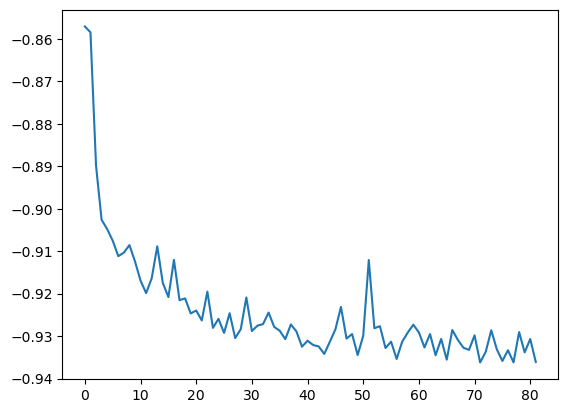

In [25]:
plt.plot(results1.history['val_loss'])

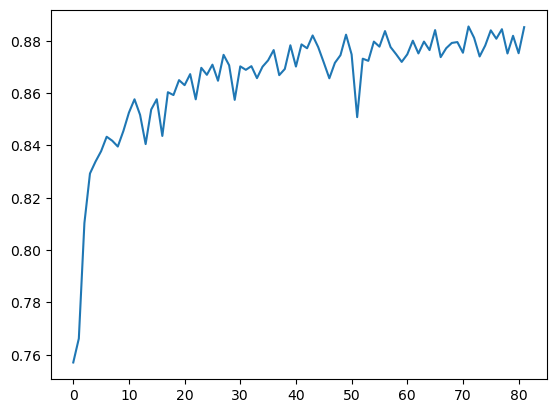

In [26]:
plt.plot(results1.history['val_iou'])

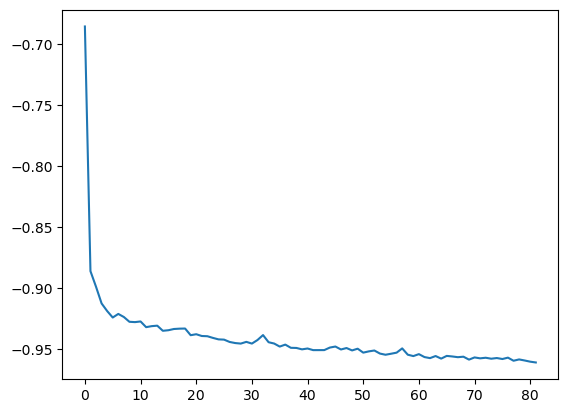

In [27]:
plt.plot(results1.history['loss'])

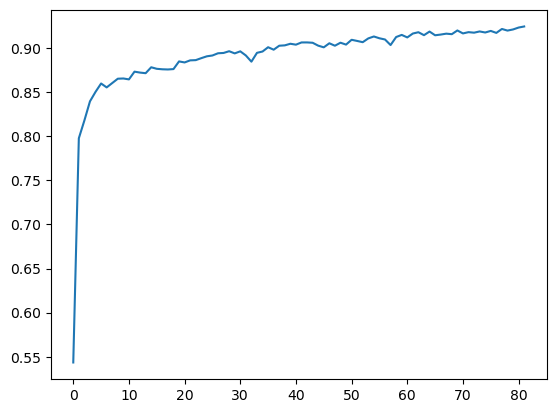

In [28]:
plt.plot(results1.history['iou'])

In [29]:
training_inferences

{'MexicanReLU': 230.6738235040002}

In [30]:
cb = TimingCallback()

UNet_2 = UNet((96, 96, 3), activation_= Swish())
model2 = UNet_2.buildModel()
UNet_2.CompileandSummarize(model2)
results2 = model2.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],  validation_data = (X_test, y_test))

training_inferences['Swish'] = sum(cb.logs)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 96, 96, 16)   448         ['input_2[0][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 96, 96, 16)   2320        ['conv2d_23[0][0]']              
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 48, 48, 16)  0           ['conv2d_24[0][0]']              
                                                                                            

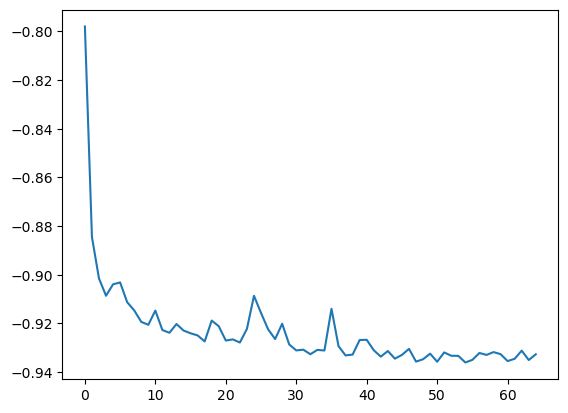

In [31]:
plt.plot(results2.history['val_loss'])

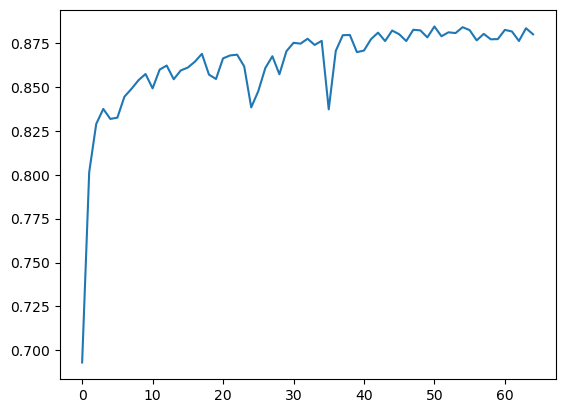

In [32]:
plt.plot(results2.history['val_iou'])

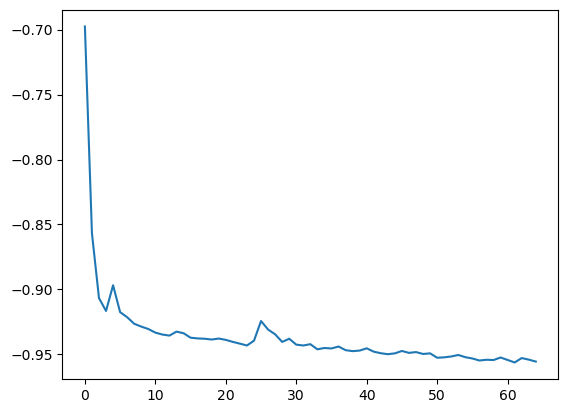

In [33]:
plt.plot(results2.history['loss'])

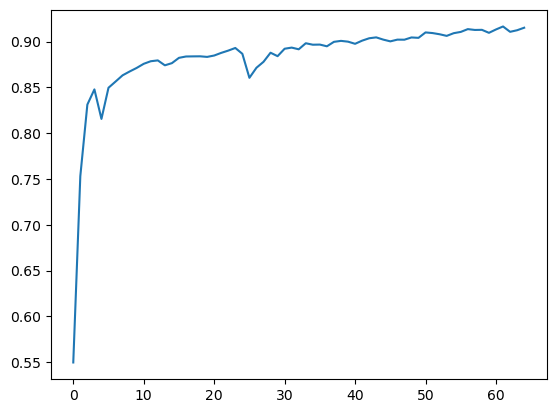

In [34]:
plt.plot(results2.history['iou'])

In [35]:
cb = TimingCallback()

UNet_3 = UNet((96, 96, 3), activation_= TrainableLeakyReLU())
model3 = UNet_3.buildModel()
UNet_3.CompileandSummarize(model3)
results3 = model3.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],  validation_data = (X_test, y_test))

training_inferences['TrainableLeakyReLU'] = sum(cb.logs)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_46 (Conv2D)             (None, 96, 96, 16)   449         ['input_3[0][0]']                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 96, 96, 16)   2321        ['conv2d_46[0][0]']              
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_47[0][0]']              
 )                                                                                          

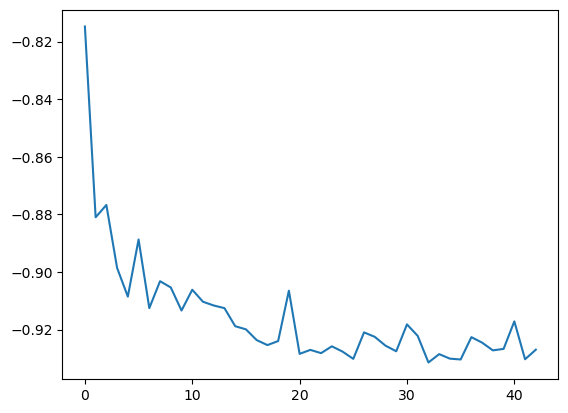

In [36]:
plt.plot(results3.history['val_loss'])

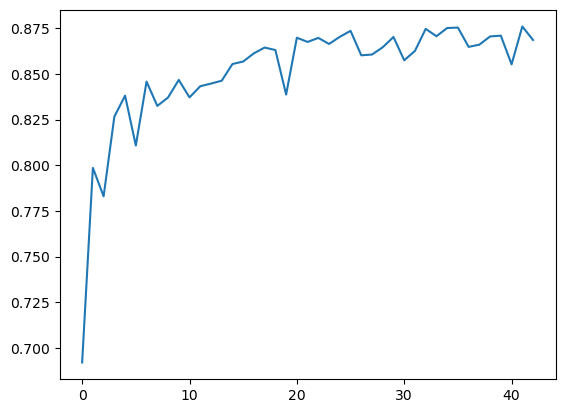

In [37]:
plt.plot(results3.history['val_iou'])

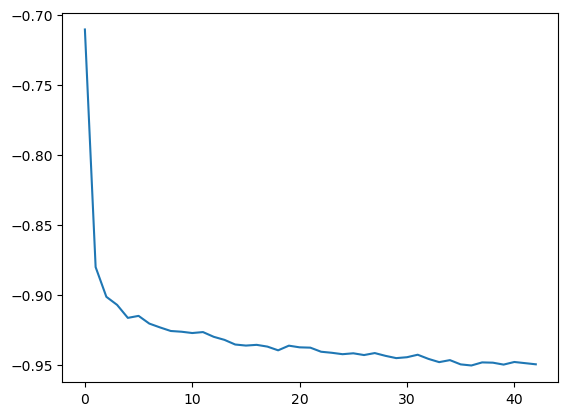

In [38]:
plt.plot(results3.history['loss'])

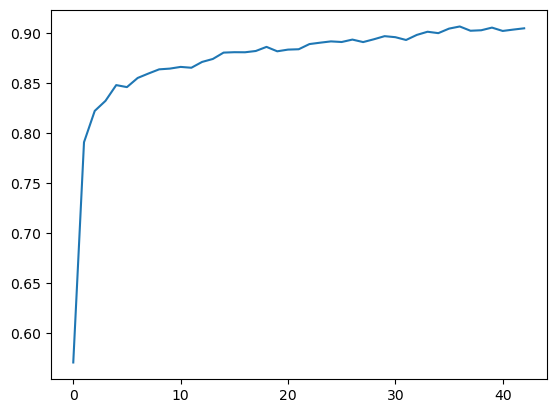

In [39]:
plt.plot(results3.history['iou'])

In [40]:
training_inferences

{'MexicanReLU': 230.6738235040002,
 'Swish': 116.92391522099933,
 'TrainableLeakyReLU': 86.49546972299959}

In [41]:
cb = TimingCallback()

UNet_4 = UNet((96, 96, 3), activation_= ISRU())
model4 = UNet_4.buildModel()
UNet_4.CompileandSummarize(model4)
results4 = model4.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['ISRU'] = sum(cb.logs)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_69 (Conv2D)             (None, 96, 96, 16)   449         ['input_4[0][0]']                
                                                                                                  
 conv2d_70 (Conv2D)             (None, 96, 96, 16)   2321        ['conv2d_69[0][0]']              
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_70[0][0]']              
 )                                                                                          

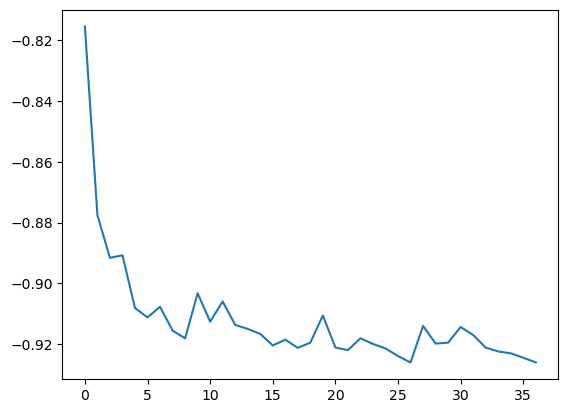

In [42]:
plt.plot(results4.history['val_loss'])

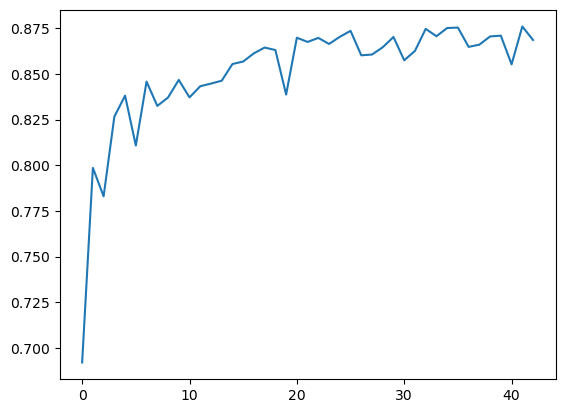

In [43]:
plt.plot(results3.history['val_iou'])

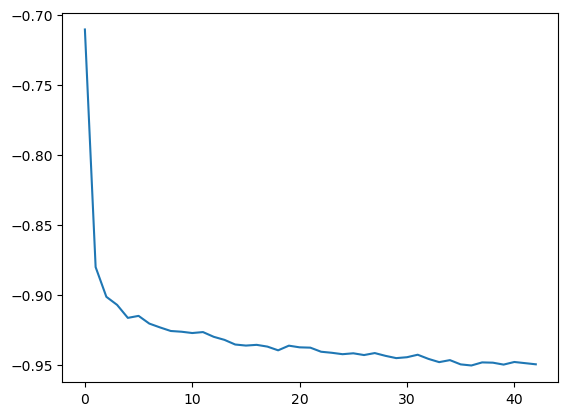

In [44]:
plt.plot(results3.history['loss'])

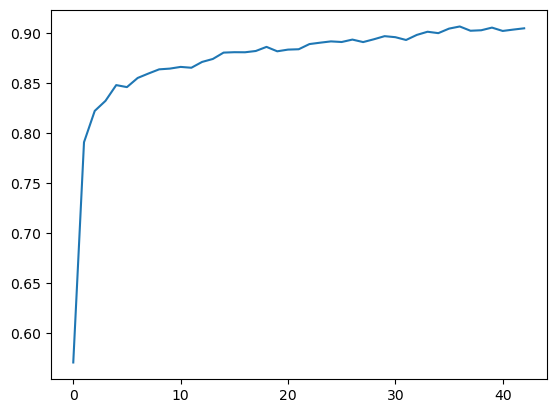

In [45]:
plt.plot(results3.history['iou'])

In [46]:
cb = TimingCallback()

UNet_5 = UNet((96, 96, 3), activation_= Mish())
model5 = UNet_5.buildModel()
UNet_5.CompileandSummarize(model5)
results5 = model5.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['Mish'] = sum(cb.logs)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_92 (Conv2D)             (None, 96, 96, 16)   448         ['input_5[0][0]']                
                                                                                                  
 conv2d_93 (Conv2D)             (None, 96, 96, 16)   2320        ['conv2d_92[0][0]']              
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_93[0][0]']              
 )                                                                                          

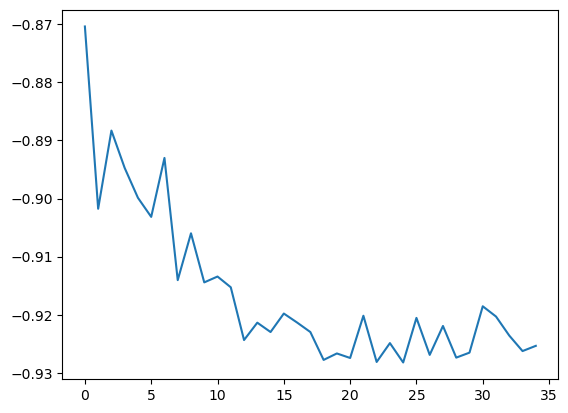

In [47]:
plt.plot(results5.history['val_loss'])

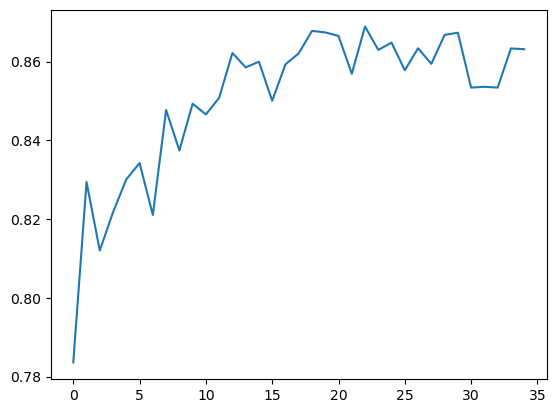

In [48]:
plt.plot(results5.history['val_iou'])

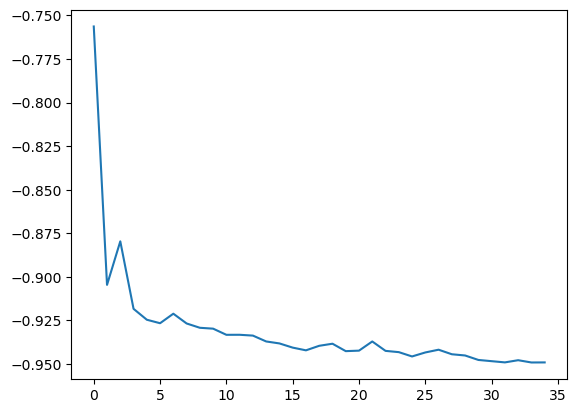

In [49]:
plt.plot(results5.history['loss'])

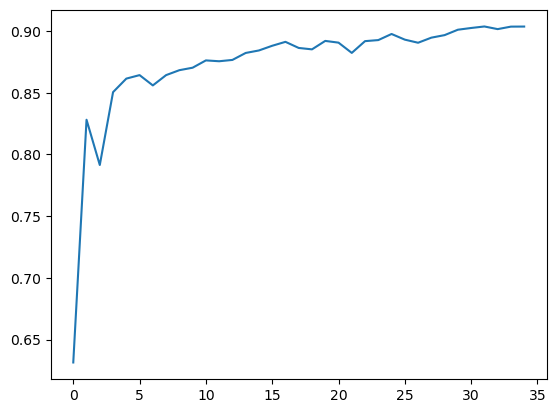

In [50]:
plt.plot(results5.history['iou'])

In [51]:
cb = TimingCallback()

UNet_6 = UNet((96, 96, 3), activation_= gated_swish())
model6 = UNet_6.buildModel()
UNet_6.CompileandSummarize(model6)
results6 = model6.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['gated_swish'] = sum(cb.logs)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_115 (Conv2D)            (None, 96, 96, 16)   448         ['input_6[0][0]']                
                                                                                                  
 conv2d_116 (Conv2D)            (None, 96, 96, 16)   2320        ['conv2d_115[0][0]']             
                                                                                                  
 max_pooling2d_25 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_116[0][0]']             
 )                                                                                          

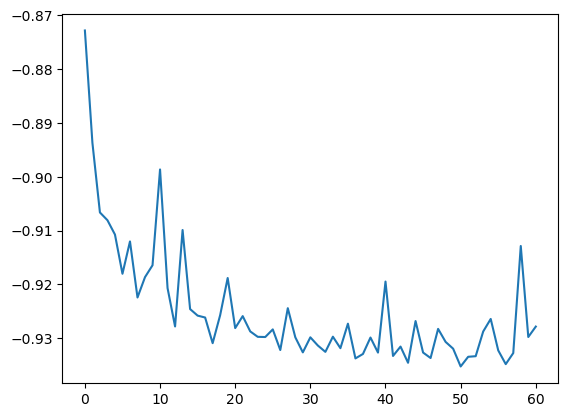

In [52]:
plt.plot(results6.history['val_loss'])

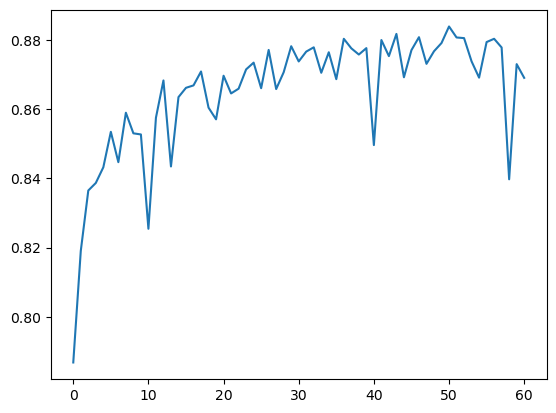

In [53]:
plt.plot(results6.history['val_iou'])

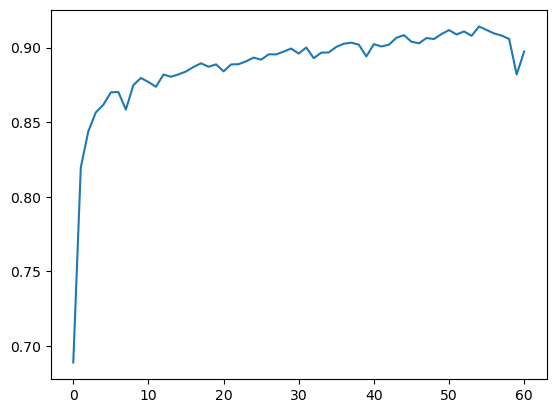

In [54]:
plt.plot(results6.history['iou'])

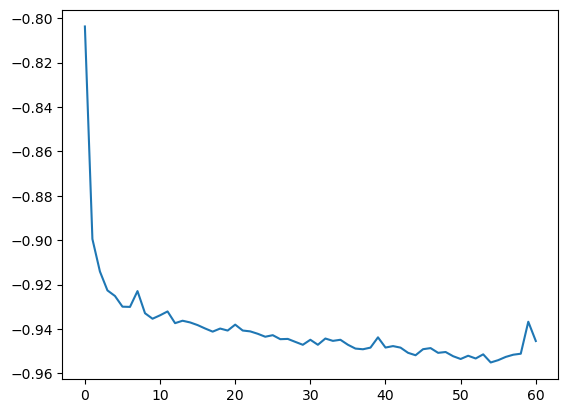

In [55]:
plt.plot(results6.history['loss'])

In [56]:
cb = TimingCallback()

UNet__ = UNet((96, 96, 3), activation_= "relu")
model_ = UNet__.buildModel()
UNet__.CompileandSummarize(model_)
results_ = model5.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['relu'] = sum(cb.logs)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_138 (Conv2D)            (None, 96, 96, 16)   448         ['input_7[0][0]']                
                                                                                                  
 conv2d_139 (Conv2D)            (None, 96, 96, 16)   2320        ['conv2d_138[0][0]']             
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_139[0][0]']             
 )                                                                                          

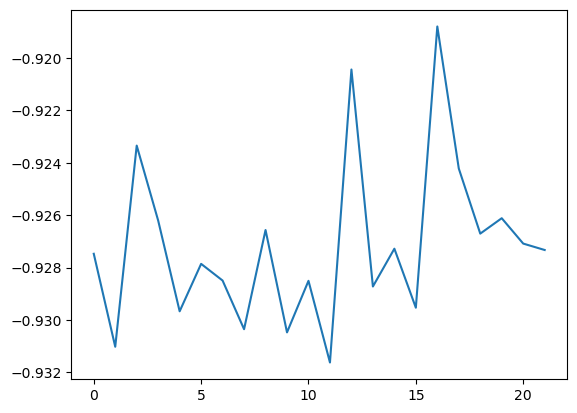

In [57]:
plt.plot(results_.history['val_loss'])

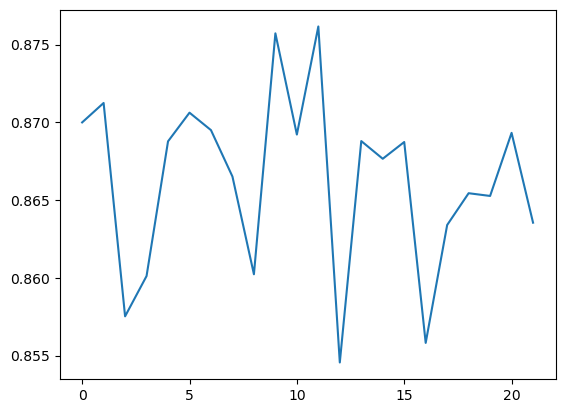

In [58]:
plt.plot(results_.history['val_iou'])

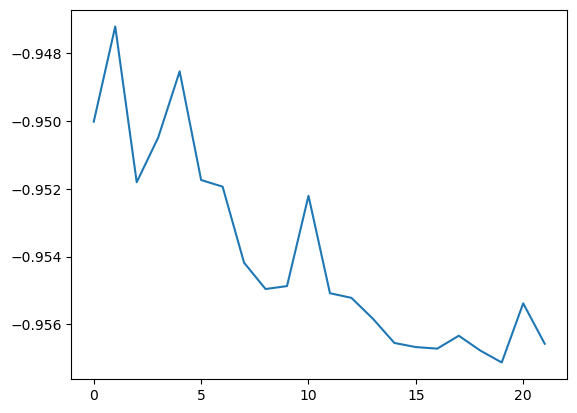

In [59]:
plt.plot(results_.history['loss'])

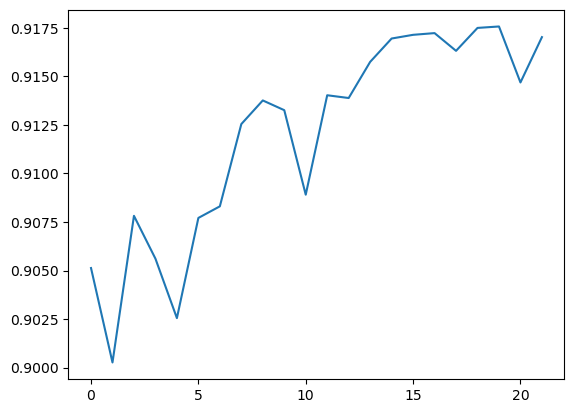

In [60]:
plt.plot(results_.history['iou'])

In [61]:
cb = TimingCallback()

UNet_ls = UNet((96, 96, 3), activation_= LearnableSwish())
modells = UNet_ls.buildModel()
UNet_ls.CompileandSummarize(modells)
resultsls = modells.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['LearnableSwish'] = sum(cb.logs)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_161 (Conv2D)            (None, 96, 96, 16)   449         ['input_8[0][0]']                
                                                                                                  
 conv2d_162 (Conv2D)            (None, 96, 96, 16)   2321        ['conv2d_161[0][0]']             
                                                                                                  
 max_pooling2d_35 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_162[0][0]']             
 )                                                                                          

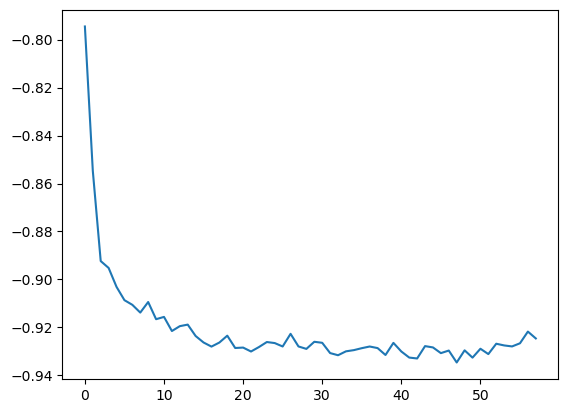

In [62]:
plt.plot(resultsls.history['val_loss'])

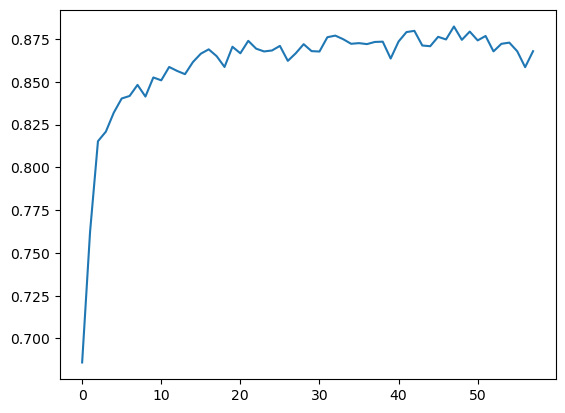

In [63]:
plt.plot(resultsls.history['val_iou'])

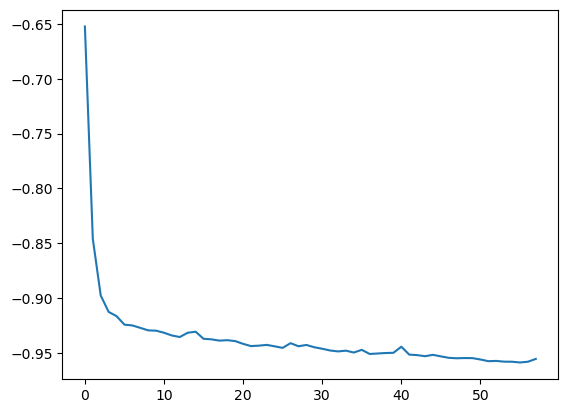

In [64]:
plt.plot(resultsls.history['loss'])

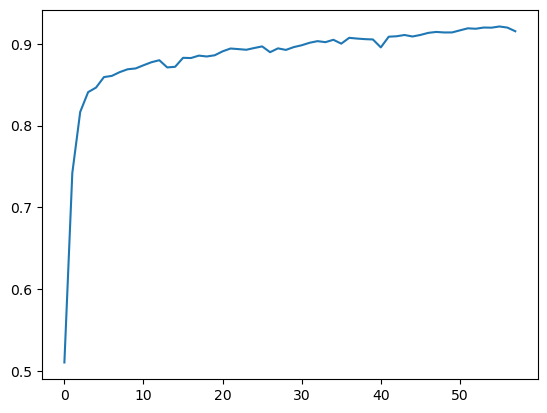

In [65]:
plt.plot(resultsls.history['iou'])

In [66]:
cb = TimingCallback()

UNet_srs = UNet((96, 96, 3), activation_= SRS())
modelsrs = UNet_srs.buildModel()
UNet_srs.CompileandSummarize(modelsrs)
resultssrs = modells.fit(x = X_train, y = Y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['SRS'] = sum(cb.logs)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_184 (Conv2D)            (None, 96, 96, 16)   448         ['input_9[0][0]']                
                                                                                                  
 conv2d_185 (Conv2D)            (None, 96, 96, 16)   2320        ['conv2d_184[0][0]']             
                                                                                                  
 max_pooling2d_40 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_185[0][0]']             
 )                                                                                          

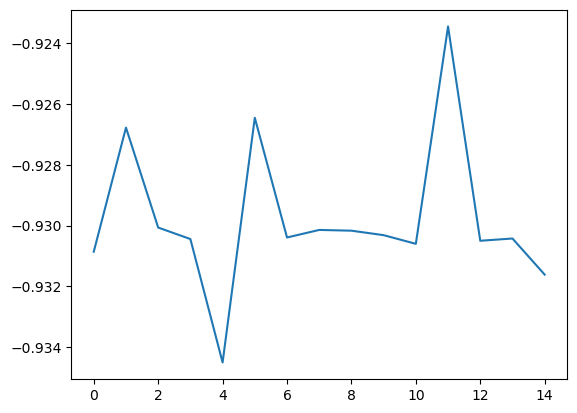

In [67]:
plt.plot(resultssrs.history['val_loss'])

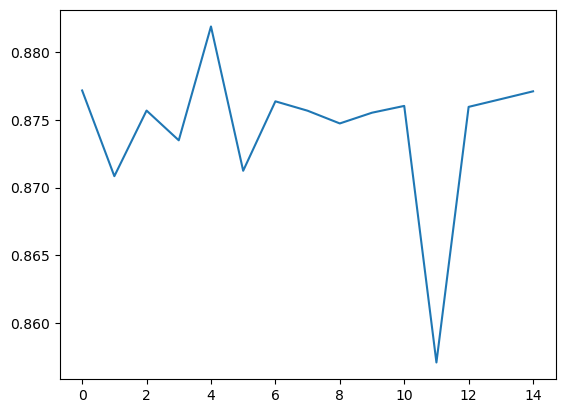

In [68]:
plt.plot(resultssrs.history['val_iou'])

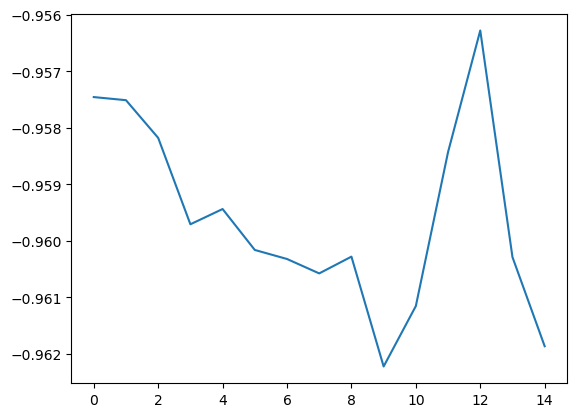

In [69]:
plt.plot(resultssrs.history['loss'])

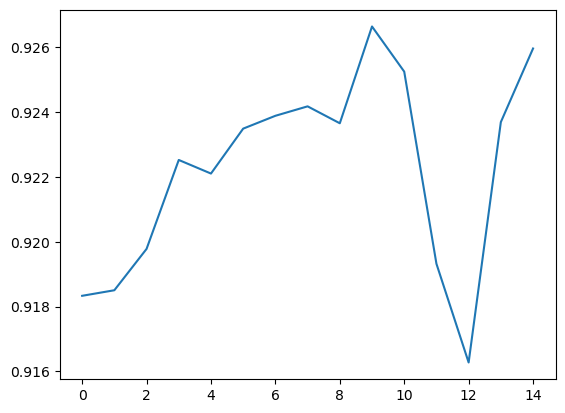

In [70]:
plt.plot(resultssrs.history['iou'])

In [71]:
training_inferences

{'MexicanReLU': 230.6738235040002,
 'Swish': 116.92391522099933,
 'TrainableLeakyReLU': 86.49546972299959,
 'ISRU': 83.85654373700027,
 'Mish': 66.68618639500028,
 'gated_swish': 121.32940289999942,
 'relu': 40.15955541000085,
 'LearnableSwish': 118.81878418299993,
 'SRS': 29.548025422998762}

In [72]:
x = []
y = []

for i in training_inferences:
    x.append(i)
    y.append(training_inferences[i])

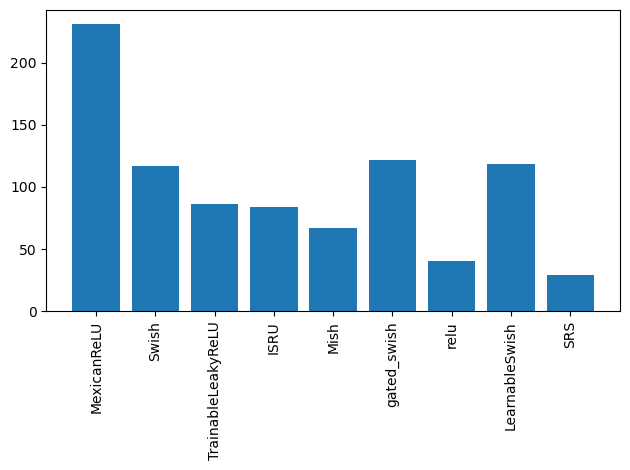

In [73]:
#'Comparision of training times in different activation functions
fig, ax = plt.subplots()
plt.bar(range(len(y)), y, tick_label=x)
plt.xticks(rotation='vertical')
fig.tight_layout()
plt.show()